In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer, util
import faiss

import torch


C:\Users\Anadu\AppData\Roaming\Python\Python310\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\Anadu\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

In [2]:
# Load datasets
resumes = pd.read_csv('data/Resume Dataset/Resume/Resume_With_Skills.csv')
jobs = pd.read_csv('data/Linkedin Job Postings (2023-2024)/cleaned_JD_with_skills.csv')

# print column names
print(resumes.columns)
print(jobs.columns)




Index(['Resume_str', 'Category', 'skills', 'roles'], dtype='object')
Index(['title', 'description', 'skills_desc', 'combined_skills_desc',
       'Clean_JD', 'skills'],
      dtype='object')


In [6]:
# Keep only the necessary columns
resumes = resumes[['Resume_str', 'skills', 'roles']]
jobs = jobs[['combined_skills_desc', 'skills', 'title']]

# print head
print(resumes.head())
# print(jobs.head())


                                          Resume_str   
0  HR ADMINISTRATOR MARKETING ASSOCIATE HR ADMINI...  \
1  HR SPECIALIST US HR OPERATIONS Summary Versati...   
2  HR DIRECTOR Summary years experience recruitin...   
3  HR SPECIALIST Summary Dedicated Driven Dynamic...   
4  HR MANAGER Skill Highlights HR SKILLS HR Depar...   

                                              skills   
0  ['accounting', 'integrity', 'customer service'...  \
1  ['support', 'training', 'process improvement',...   
2  ['databases', 'box', 'support', 'tracking syst...   
3  ['training', 'customer service', 'documentatio...   
4  ['support', 'training', 'problem solving', 'in...   

                                               roles  
0  HR ADMINISTRATOR MARKETING ASSOCIATE HR ADMINI...  
1  HR SPECIALIST US HR OPERATIONS, HR, US HR, HR,...  
2  HR DIRECTOR, HRIS, FMLA EEO FLSA HRIS, SHRM, A...  
3                            HR SPECIALIST, HR, FMLA  
4  HR MANAGER, HR SKILLS HR, FMLA ADA EEO WC, HR,..

In [4]:
# Rename columns
resumes = resumes.rename(columns={'Resume_str': 'text'})
jobs = jobs.rename(columns={'combined_skills_desc': 'text'})

# Drop rows with missing values
resumes = resumes.dropna()
jobs = jobs.dropna()

# Convert lists to strings if necessary
resumes['skills'] = resumes['skills'].astype(str)
jobs['skills'] = jobs['skills'].astype(str)

# shape of the datasets
print(resumes.shape)
print(jobs.shape)

(2480, 3)
(2439, 3)


In [5]:
# head of the datasets
print(resumes.head())
print(jobs.head())

                                                text   
0  HR ADMINISTRATOR MARKETING ASSOCIATE HR ADMINI...  \
1  HR SPECIALIST US HR OPERATIONS Summary Versati...   
2  HR DIRECTOR Summary years experience recruitin...   
3  HR SPECIALIST Summary Dedicated Driven Dynamic...   
4  HR MANAGER Skill Highlights HR SKILLS HR Depar...   

                                              skills   
0  ['accounting', 'integrity', 'customer service'...  \
1  ['support', 'training', 'process improvement',...   
2  ['databases', 'box', 'support', 'tracking syst...   
3  ['training', 'customer service', 'documentatio...   
4  ['support', 'training', 'problem solving', 'in...   

                                               roles  
0  HR ADMINISTRATOR MARKETING ASSOCIATE HR ADMINI...  
1  HR SPECIALIST US HR OPERATIONS, HR, US HR, HR,...  
2  HR DIRECTOR, HRIS, FMLA EEO FLSA HRIS, SHRM, A...  
3                            HR SPECIALIST, HR, FMLA  
4  HR MANAGER, HR SKILLS HR, FMLA ADA EEO WC, HR,..

In [6]:
# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight model, good for scalability

In [7]:
# Encode all resumes
resume_embeddings = model.encode(resumes['text'].tolist(), convert_to_tensor=True)

# Encode all job descriptions
job_embeddings = model.encode(jobs['text'].tolist(), convert_to_tensor=True)

In [8]:
# Store resume embeddings in FAISS
resume_index = faiss.IndexFlatL2(resume_embeddings.shape[1])
resume_index.add(resume_embeddings.cpu().numpy())

# Store job embeddings in FAISS
job_index = faiss.IndexFlatL2(job_embeddings.shape[1])
job_index.add(job_embeddings.cpu().numpy())

In [27]:
from sklearn.cluster import KMeans

# Combine resume and job embeddings
all_embeddings = np.vstack((resume_embeddings, job_embeddings))

# Define number of clusters
num_clusters = 5  # Adjust based on dataset size

# Apply K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

# Assign labels back to dataframes
resumes['cluster'] = cluster_labels[:len(resumes)]
jobs['cluster'] = cluster_labels[len(resumes):]

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Store PCA results
resumes['pca_x'], resumes['pca_y'] = reduced_embeddings[:len(resumes), 0], reduced_embeddings[:len(resumes), 1]
jobs['pca_x'], jobs['pca_y'] = reduced_embeddings[len(resumes):, 0], reduced_embeddings[len(resumes):, 1]

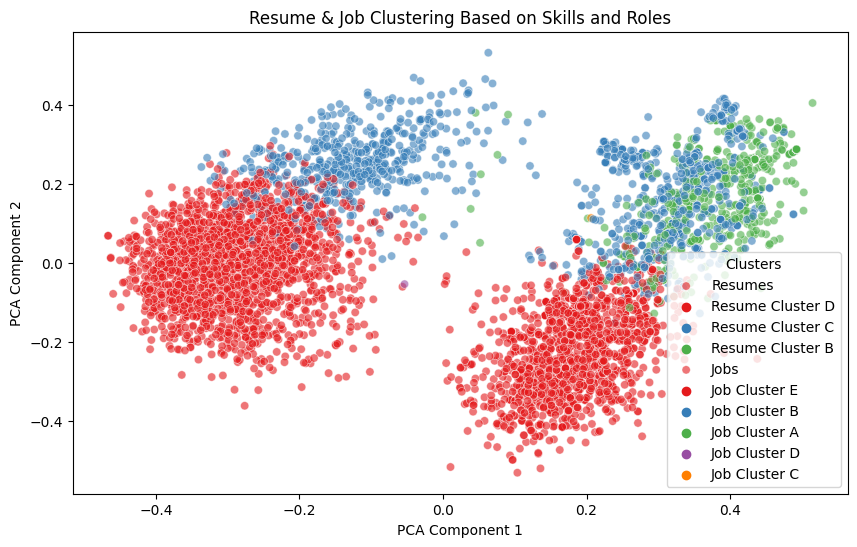

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert numerical cluster labels to meaningful categories
resume_cluster_map = {0: "Resume Cluster A", 1: "Resume Cluster B", 2: "Resume Cluster C", 3: "Resume Cluster D"}
job_cluster_map = {0: "Job Cluster A", 1: "Job Cluster B", 2: "Job Cluster C", 3: "Job Cluster D", 4: "Job Cluster E"}

# Map clusters to names
resumes['cluster'] = resumes['cluster'].map(resume_cluster_map)
jobs['cluster'] = jobs['cluster'].map(job_cluster_map)

# Re-plot with clearer labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=resumes['pca_x'], y=resumes['pca_y'], hue=resumes['cluster'], palette="Set1", label="Resumes", alpha=0.6)
sns.scatterplot(x=jobs['pca_x'], y=jobs['pca_y'], hue=jobs['cluster'], palette="Set1", label="Jobs", alpha=0.6)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Resume & Job Clustering Based on Skills and Roles")
plt.legend(title="Clusters")
plt.show()

KeyError: 'Category'

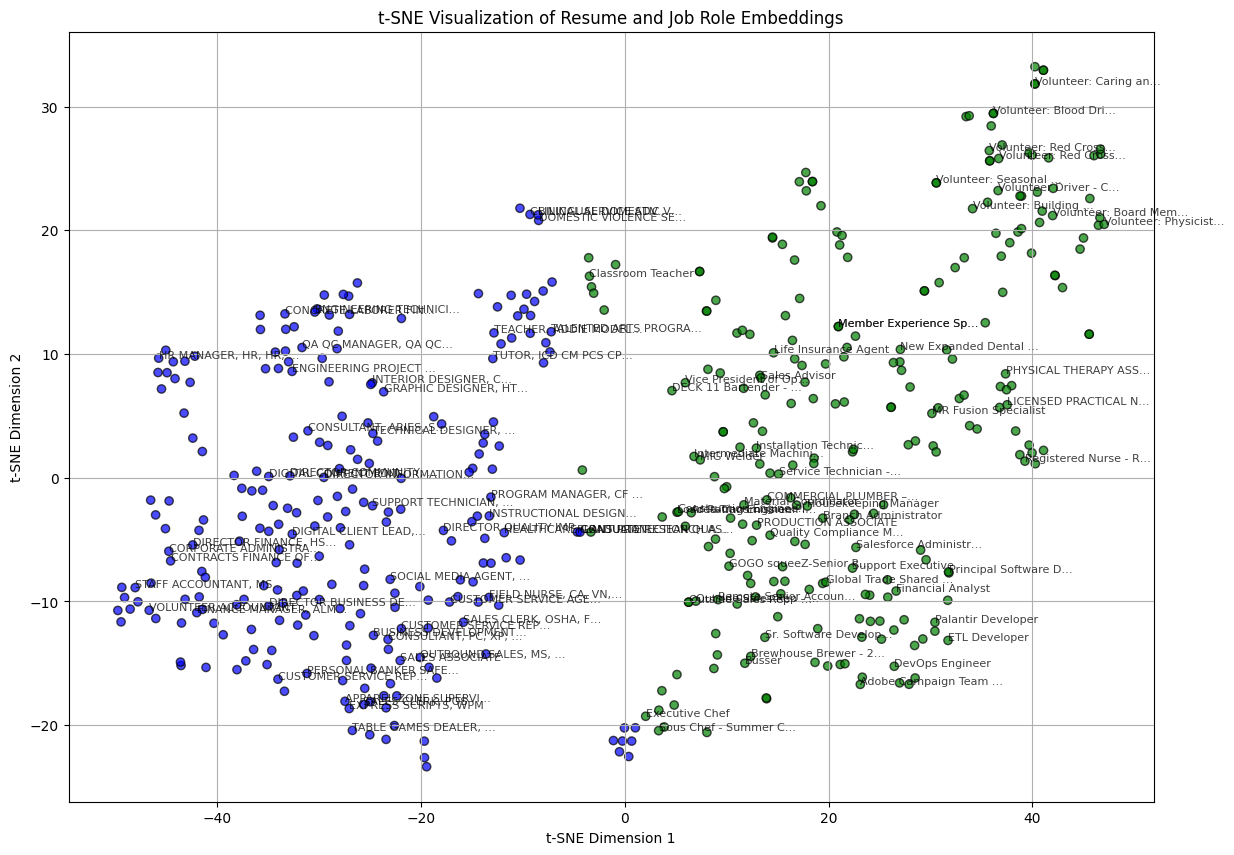

In [9]:
from sklearn.decomposition import PCA

def plot_role_embeddings(resume_embeddings, job_embeddings, resume_roles, job_roles, max_samples=500, label_every_n=5, max_label_length=20):
    """
    Creates a 2D scatter plot of resume and job role embeddings using t-SNE, labeling only with role names.
    
    Parameters:
        - resume_embeddings: numpy array of resume role embeddings
        - job_embeddings: numpy array of job role embeddings
        - resume_roles: list of resume role names
        - job_roles: list of job role names
        - max_samples: Maximum number of data points to plot
    """
    # Convert tensors to NumPy if needed
    if hasattr(resume_embeddings, "cpu"):
        resume_embeddings = resume_embeddings.cpu().numpy()
    if hasattr(job_embeddings, "cpu"):
        job_embeddings = job_embeddings.cpu().numpy()

    # Combine all embeddings and labels
    all_embeddings = np.vstack([resume_embeddings, job_embeddings])
    all_labels = resume_roles + job_roles  # Only role names, no prefixes

    # Subsample data if too large
    sample_size = min(max_samples, len(all_embeddings))
    indices = np.random.choice(len(all_embeddings), sample_size, replace=False)
    
    reduced_embeddings = all_embeddings[indices]
    reduced_labels = [all_labels[i] for i in indices]

    # Apply PCA first to reduce dimensions from high-D to 50D
    pca = PCA(n_components=50, random_state=42)
    pca_embeddings = pca.fit_transform(reduced_embeddings)

    # Reduce embedding dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    tsne_embeddings = tsne.fit_transform(pca_embeddings)

    # Assign colors for resumes and jobs
    resume_colors = ['blue'] * len(resume_embeddings)
    job_colors = ['green'] * len(job_embeddings)
    all_colors = np.array(resume_colors + job_colors)[indices]  # Subsample colors too

    # Plot embeddings
    plt.figure(figsize=(14, 10))
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 
                c=all_colors, alpha=0.7, edgecolors='k')

    # Annotate every nth point to avoid clutter, truncating long role names
    for i in range(0, len(reduced_labels), label_every_n):
        truncated_label = (reduced_labels[i][:max_label_length] + '…') if len(reduced_labels[i]) > max_label_length else reduced_labels[i]
        plt.annotate(truncated_label, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]), fontsize=8, alpha=0.75)

    plt.title("t-SNE Visualization of Resume and Job Role Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

# Example Usage (Make sure to replace with actual embeddings & roles)
plot_role_embeddings(resume_embeddings, job_embeddings, resumes['roles'].tolist(), jobs['roles'].tolist())

In [10]:
def recommend_jobs_from_text(resume_text, top_k=5):
    """Encodes a raw resume and finds the most similar job descriptions with a percentage match."""
    # Encode resume into an embedding
    resume_embedding = model.encode([resume_text], convert_to_tensor=True)

    # Compute cosine similarity between the resume and all job embeddings
    similarities = util.pytorch_cos_sim(resume_embedding, job_embeddings)[0]

    # Get the indices of the top-k most similar job descriptions
    top_indices = torch.argsort(similarities, descending=True)[:top_k].tolist()  # Convert to list

    # Retrieve matching job details with percentage match
    recommended_jobs = [
        {
            "Job Title": jobs.iloc[idx]['roles'],
            "Skills Required": jobs.iloc[idx]['skills'],
            "Job Description": jobs.iloc[idx]['text'],  # Assuming this is the job text
            "Match Percentage": round(similarities[idx].item() * 100, 2)  # Convert to percentage
        }
        for idx in top_indices
    ]
    
    return recommended_jobs

In [11]:
# Example: User submits a resume in plain text
user_resume_text = """
NIGEL TEO
 (+65) 93599982 | nigel.teo@u.nus.edu | linkedin.com/in/nigelteosw
 EDUCATION 
National University of Singapore (NUS)
 Bachelor of Computing in Computer Science
 Aug 2021 - Present
 Programming Coursework: Software Engineering, Networks, Data Structures & Algorithms,
 AI
 Expected Graduation: December 2025
 Tembusu College
 The Ngee Ann Kongsi Residential College Scholarship (AY23/24)
 TECHNICAL SKILLS
 Aug 2021 - Apr 2024
 Programming Language: Python, Java, Javascript, Typescript, React JS, C#, C, SQL, HTML,
 CSS
 Data Visualisation Software: Microsoft Power BI
 PROJECTS
 Healthier SG Admin Repository (HSAR)
 Synapxe
 Jan 2024 - Jun 2024
 Designed and built a full-stack feature from aimed at streamlining the resolution of
 erroneous patient records by providing internal engineers with a dashboard interface to
 help troubleshoot issues
 Collaborated with the UI/UX team to create visually appealing interfaces
 Authored comprehensive documentation for the feature, including sequence diagrams
 Technologies Used: React JS, Typescript, C#, MSSQL, Figma
 Protein Database
 Introduction to Introduction to Computational Biology (CS2220)
 Sep 2023 - Nov 2023
 Enabled users to search for specific proteins and protein interactions, with sorting and
 filtering functions
 Implemented navigation across different sections of the website.
 Technologies Used: React, Next.js, Material-UI, Planetscale for data storage (database as
 a service)
 Well Informed Fridge Environment
 Software Engineering (CS2103)
 Improved User Interface (UI) for displaying fridge contents
 Dynamic panel display feature
 Technologies Used: Java, Java.fx
 WORK EXPERIENCE
 Jan 2023 - Apr 2023
 Software Engineering Intern, Synapxe
 Jan 2024 - Jun 2024
 Increased understanding of technical stacks, including AWS Cloud, MS SQL, Azure
 DevOps, and CI/CD
 Gained practical experience with the software development life cycle (SDLC),
 encompassing all stages from development to deployment and maintenance of
 commercial-level applications
Human Resources Assistant, Frasers Hospitality
 Jun 2023 - Aug 2023
 Developed compelling data visualizations using Microsoft Power BI to illustrate
 comprehensive headcount statistics
 Expertly consolidated and managed data from multiple properties worldwide,
 strengthening global workforce analysis
 Intern Web Developer, Cognotiv Pte Ltd
 Dec 2021 - Jan 2022
 Cooperated with a team to make changes and alterations to the frontend based on
 specific design specifications
 Helped to achieve a consistent look and visual theme across the website by designing
 the wireframes ensuring uniform fonts and layout
 CO-CURRICULAR ACTIVITIES
 Publicity Director, NUS Rovers
 Jan 2024 - Dec 2024
 Collaborated with a team to design and distribute engaging publicity materials, to
 maximize reach and engagement in the NUS community
 Utilized social media platforms and other channels to promote hikes and events,
 enhancing the club's visibility
 Tancho House Captain
 Sep 2022 - Apr 2023
 Led a team to organize engaging and successful events for Tancho House, fostering
 community spirit and participation
 Implemented comprehensive event plans, including budgeting and marketing strategies
 Improved team collaboration and communication by facilitating regular meetings and
 promoting a supportive environment
 tStudios Head
 Jan 2022 - Dec 2023
 Coordinated a team to organize events such as film walks, enhancing the skills and
 engagement of college residents
 Supervised the loaning of camera equipment, ensuring proper usage and maintenance
 for club members
 Mentored volunteers to photograph college events, ensuring comprehensive coverage
 and high-quality images
 INTRESTS
 Photography, Floorball, Travelling

"""

recommended_jobs = recommend_jobs_from_text(user_resume_text, top_k=10)

# Print recommended jobs with match percentage
print("\nRecommended Jobs:")
for i, job in enumerate(recommended_jobs, 1):
    print(f"{i}. Job Title: {job['Job Title']} (Match: {job['Match Percentage']}%)")
    # print(f"   Skills Required: {job['Skills Required']}")
    # print(f"   Job Description: {job['Job Description']}\n")
    print("\n")


Recommended Jobs:
1. Job Title: Volunteer: Database Architect (Match: 52.15%)


2. Job Title: Sr Embedded SW Test Engineer (Northridge, CA) (Match: 49.75%)


3. Job Title: Palantir Developer (Match: 49.63%)


4. Job Title: Data Platform Engineer Data Mesh/Virtualization (Match: 47.92%)


5. Job Title: Electronic Visit Verification Support (Match: 46.6%)


6. Job Title: Senior Scientific Project Manager - Genomics (Match: 46.5%)


7. Job Title: Documentation Specialist (Match: 46.24%)


8. Job Title: Medical Coding Supervisor (Match: 45.65%)


9. Job Title: Medical Coding Supervisor (Match: 45.65%)


10. Job Title: Volunteer: Back-end Technical Mentor (Match: 45.63%)




In [36]:
def recommend_resumes_for_job(job_idx, top_k=5):
    """Finds the most similar resumes for a given job index using FAISS."""
    # Retrieve job embedding
    job_embedding = job_embeddings[job_idx].unsqueeze(0)

    # Search for closest resume embeddings
    _, indices = resume_index.search(job_embedding.cpu().numpy(), top_k)

    # Retrieve matching resumes
    recommended_resumes = [
        {
            "Resume Role": resumes.iloc[idx]['roles'],
            "Candidate Skills": resumes.iloc[idx]['skills'],
            "Resume Text": resumes.iloc[idx]['text']
        }
        for idx in indices[0]
    ]
    
    return recommended_resumes

# Example Usage
job_idx = 2  # Assuming we want to match resumes to the first job in the dataset

# print the job
print(jobs.iloc[job_idx])

recommended_resumes = recommend_resumes_for_job(job_idx, top_k=5)

# Print recommended resumes
print("\nRecommended Resumes:")
for i, resume in enumerate(recommended_resumes, 1):
    print(f"{i}. Resume Role: {resume['Resume Role']}")
    print(f"   Candidate Skills: {resume['Candidate Skills']}")
    print(f"   Resume Text: {resume['Resume Text']}\n")

text      senior associate attorney elder law trusts and...
skills                 ['problem solving', 'search engine']
roles     Senior Elder Law / Trusts and Estates Associat...
Name: 2, dtype: object

Recommended Resumes:
1. Resume Role: CONSULTANT, U C, SEC DOJ, SAR, ERISA RICO, GPA, GPA
   Candidate Skills: ['organization', 'communications', 'documentation', 'communication', 'leadership', 'risk management']
   Resume Text: CONSULTANT Professional Summary Astute innovative attorney strong ability develop implement effective litigation case strategies write persuasive motions Proven ability resolve complex cases clients favor Meticulous conscientious tenacious organized analytical able thrive dynamic environments Skills Court Procedures Legal Document Preparation Strong Researcher Strong Negotiator Organization Communication Leadership Team Player Litigation Management Detailed Oriented Due Dilligence Deposition Motion Practice Regulatory Compliance Risk Management Strong Writer Civ